# TODO:
    1. check result in case of using stop-words
    2. use over sampling to correct imbalance dataset problem. the result will definitely improve.

# import essential libraries

In [1]:
from __future__ import unicode_literals # hazm

import numpy as np # linear Algebra 
import pandas as pd # data Manipulation

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to show diagrams in cells
%matplotlib inline

# text preprocessing
from string import punctuation

# persian text processing
from hazm import Normalizer, Lemmatizer, word_tokenize, Stemmer

In [2]:
directory = '/home/mehrdad/Downloads/Projects_Jupyter/KhorshidSoft_Interview_Project/'
df_origin = pd.read_json(directory + 'sample_dataset.json.txt')
df = df_origin

# sentiment distribution

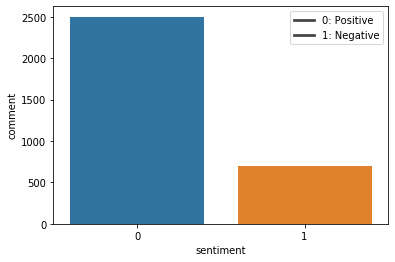

In [3]:
sentiment_distribution = df.groupby('sentiment').count()
sentiment_distribution.reset_index(inplace=True)
sns.barplot(x='sentiment', y='comment', data=sentiment_distribution)
plt.legend(labels=['0: Positive', '1: Negative'])

# preprocessing and cleaning data

### normalizing text - for example: removing Arabic ی

In [4]:
normalizer = Normalizer()
df['comment'] = df['comment'].apply(lambda text: normalizer.normalize(text))

### removing \u200c character form text

In [5]:
punctuation = punctuation + '‌' # To remove "\u200c" (shift+space) in persian text
punctuation = punctuation + '۰۱۲۳۴۵۶۷۸۹' # To remove persian numbers
punctuation = punctuation + '.،…' # To remove persian comma and full stop

### removing punctuations form text

In [6]:
def remove_punc(word):
    final_word = ''
    for i in word:
        if i not in punctuation:
            final_word = final_word + i
        else:
            final_word = final_word + " "
    return final_word

In [7]:
df['comment'] = df['comment'].apply(lambda x: remove_punc(x))

### Tokenization

In [8]:
df['tokens'] = df['comment'].apply(lambda text: word_tokenize(text))

### lemmatize

In [9]:
def toeknToLemma(text):
    mList = []
    for i in text:
        mList.append(lemmatizer.lemmatize(i))
    return mList

In [10]:
lemmatizer = Lemmatizer()
df['lemmas'] = df['tokens'].apply(lambda text: toeknToLemma(text))

### removing stop words
Because our dataset is small, I want to keep data as much as I can, so I won't remove stop words.

some important words like 'good' and 'bad' are in 'StopWords'

In [11]:
def removeStopWords(words):
    df_persian_stop_words = pd.read_csv('STOPWORDS',
                                    header=None)
    df_persian_stop_words.columns = ['word']
    persian_stop_words = []
    
    df_persian_stop_words['word'].apply(lambda x: persian_stop_words.append(x));
    
    result = [x for x in words if x not in persian_stop_words]
    
    del df_persian_stop_words, persian_stop_words
    return result

In [12]:
df['no_stop_words'] = df['lemmas'].apply(lambda text: removeStopWords(text))

### Encoding the words

In [13]:
all_tokens = []

for i in range(len(df)):
    for j in range(len(df['lemmas'][i])):
        all_tokens.append(df['lemmas'][i][j])

print('total tokens: {}'.format(len(all_tokens)))

total tokens: 55740


In [14]:
from collections import Counter
counts = Counter(all_tokens)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}


print('total tokens(vocab size): {}'.format(len(vocab)))
print('Most common words are:')
counts.most_common(5)

total tokens(vocab size): 4702
Most common words are:


[('و', 2491), ('از', 1342), ('به', 1170), ('که', 1050), ('خیلی', 994)]

In [15]:
reviews_ints = []
for each in df['lemmas']:
    reviews_ints.append([vocab_to_int[word] for word in each])

### review stats

In [16]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 221


In [17]:
max_review_length = max(review_lens)
print(len(df))
print(len(reviews_ints))

3200
3200


In [18]:
indexes_to_be_removed = [i for i, value in enumerate(reviews_ints, 0)  if len(value) == 0]
for i in range(len(df)):
    if(i in indexes_to_be_removed):
        df.drop(index=i, inplace=True)

### Filter out that review with 0 length

In [19]:
reviews_ints = [each for each in reviews_ints if len(each) > 0]

In [20]:
seq_len = max_review_length
features = np.zeros((len(reviews_ints), seq_len), dtype=int)
for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_len]

In [21]:
labels = df['sentiment']

In [22]:
print(len(df))
print(len(reviews_ints))
print(len(labels))

3199
3199
3199


In [23]:
features.shape

(3199, 221)

In [24]:
features[0:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

## Building RNN model with word_embedding and LSTM

In [25]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(2559, 221) 
Validation set: 	(320, 221) 
Test set: 		(320, 221)


### Building the model

In [26]:
# Build the model 

from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.embeddings import Embedding
from keras.layers import LSTM

embedding_vector_length = 200
model = Sequential() 
model.add(Embedding(len(vocab)+1, embedding_vector_length, input_length=max_review_length)) 
model.add(LSTM(100)) 
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy']) 
print(model.summary()) 

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 221, 200)          940600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,061,101
Trainable params: 1,061,101
Non-trainable params: 0
_________________________________________________________________
None


### Train model

In [27]:
model.fit(train_x, train_y, validation_data=(test_x, test_y), nb_epoch=3, batch_size=64) #batch_size=64

/home/mehrdad/Downloads/anaconda3/envs/nlp/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.
/home/mehrdad/Downloads/anaconda3/envs/nlp/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2559 samples, validate on 320 samples
Epoch 1/3
2559/2559 [==============================] - 32s 13ms/step - loss: 0.5305 - accuracy: 0.7730 - val_loss: 0.4406 - val_accuracy: 0.7844
Epoch 2/3
2559/2559 [==============================] - 39s 15ms/step - loss: 0.3174 - accuracy: 0.8542 - val_loss: 0.3160 - val_accuracy: 0.8781
Epoch 3/3
2559/2559 [==============================] - 43s 17ms/step - loss: 0.1857 - accuracy: 0.9301 - val_loss: 0.3413 - val_accuracy: 0.8750


In [28]:
#Evaluate the model
scores = model.evaluate(test_x, test_y, verbose=0) 
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.50%


In [29]:
def clean_text(text):
    text = normalizer.normalize(text)
    text = remove_punc(text)
    text = word_tokenize(text)
    text = toeknToLemma(text)
    
    reviews_int = [vocab_to_int[word] for word in text]
    
    seq_len = max_review_length
    features = np.zeros(seq_len, dtype=int)
#     for i in reviews_ints:
    features[-len(reviews_int):] = np.array(reviews_int)[:seq_len]
    return features

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [31]:
review = 'متاسفانه بخاطر تعریف های زیادی که ازش شده بود خریدم  اصلا روی جوش تاثیری نداره  پوست رو فوق العاده خشک و کدر میکنه '
review = clean_text(review)
model.predict(review.reshape(1, -1))

array([[0.9789677]], dtype=float32)

# Testing Model
    output interpretation:
        near 1: negative
        near 0: positive

### example 1

In [32]:
i = 31
print(df_origin['sentiment'][i])
print(df_origin['comment'][i])

review =  df_origin['comment'][i]
review = clean_text(review)
model.predict(review.reshape(1, -1))

1
خیلی بده اصلا به درد نمیخوره


array([[0.98242676]], dtype=float32)

### example 2

In [33]:
i = 61
print(df_origin['sentiment'][i])
print(df_origin['comment'][i])

review =  df_origin['comment'][i]
review = clean_text(review)
model.predict(review.reshape(1, -1))

0
برای پوستای چرب واقعا ایده آل هستش  هم آبرسانی خوبی داره هم زود جذب میشه  بوش هم عالیه


array([[0.00049004]], dtype=float32)

### example 3

In [34]:
i = 1002
print(df_origin['sentiment'][i])
print(df_origin['comment'][i])

review =  df_origin['comment'][i]
review = clean_text(review)
model.predict(review.reshape(1, -1))

0
بسیار با کیفیت وسرعت شارز سریع برابی نوت   ممنون از دی جی کالا من یکی خریدم یکی هم هدیه دادن


array([[0.00302509]], dtype=float32)

### example 4 - answer is not good nor bad

In [35]:
i = 1001
print(df_origin['sentiment'][i])
print(df_origin['comment'][i])

review =  df_origin['comment'][i]
review = clean_text(review)
model.predict(review.reshape(1, -1))

0
اونجوری که انتظار داشتم  موهای زائد رو جدا نمیکنه از پوست  ولی در کل خوبه


array([[0.00201276]], dtype=float32)

### example 5 - answer is not good nor bad

In [36]:
i = 2000
print(df_origin['sentiment'][i])
print(df_origin['comment'][i])

review =  df_origin['comment'][i]
review = clean_text(review)
model.predict(review.reshape(1, -1))

0
من اینو استفاده کردم خاصیت آبرسانی و مرطوب کنندگی عالی و بدون چربی و سبک مناسب ساختار پوست آقایان و رایحه عالی  به سلامتی خود اهمیت بدهیم


array([[0.01065985]], dtype=float32)

### example 5 - answer is not good nor bad

In [37]:
i = 3007
print(df_origin['sentiment'][i])
print(df_origin['comment'][i])

review =  df_origin['comment'][i]
review = clean_text(review)
model.predict(review.reshape(1, -1))

1
به هیچ عنوان کارایی ندارد  تا وارد دندان شده پاره میشود و آزار دهنده است


array([[0.42215022]], dtype=float32)